Тут немного читерства, загружена roc_auc_score. что бы не загружать каждый раз на сайт. если это совсем незаконно то можно неучитывать исследования сделанные с ним. Сам я его быстро написать не смог.

In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [83]:

def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

def log_safe(a):
    """
    Safe log for sigmoid, cant be -inf
    """
    l = np.log(a)
    if -np.inf in l:
        l[l == -np.inf] = -99999 
    return l

def calc_logloss(y, y_pred):
    err = - np.mean(y * log_safe(y_pred) + (1.0 - y) * log_safe(1.0 - y_pred))
    return err

def eval_model(X, y, iterations=1000, alpha=1e-4):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for_graph = []
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        for_graph.append([i, err])
    return W, err, for_graph

def calc_pred_proba(w, x):
    return sigmoid(np.dot(w, x))


def calc_pred(w, x, threshold=0.5):
    pred = calc_pred_proba(w, x)
    pred[pred >= threshold] = 1
    pred[pred != 1] = 0
    return pred 


Немного функций для работы с данными.

In [84]:
def pop(data:pd.DataFrame, categories:tuple)-> pd.DataFrame:
    """
    Pop columns from data with names from categories tuple. 
    """
    for i in categories:
        data.pop(i)
    return data

def normilize(data:pd.DataFrame, features:tuple) -> pd.DataFrame:
    """
    Normilize columns in data with names from features tuple.
    """
    for feature in features:
        min_value = data.loc[:, feature].min()
        max_value = data.loc[:, feature].max()
        data.loc[:, feature] = (data.loc[:, feature] - min_value) / (max_value - min_value)
    return data

def standartize(data:pd.DataFrame, features:tuple) -> pd.DataFrame:
    """
    Standartize columns in data with names from features tuple.
    """
    for feature in features:
        length = data.shape[0]
        mean = data.loc[:,feature].mean()
        dispersion = np.sqrt(((data.loc[:,feature] - mean) ** 2 ).sum()/ length)
        data.loc[:, feature] = (data.loc[:,feature] - mean) / dispersion
    return data

def features_in_powers(data:pd.DataFrame, categories:tuple, powers:tuple):
    """
    Creates new features like feature in some power. Return data with new features and list
        of new features names. 
    categories: tuple of features names to be powered.
    powers: tuple of powers which every feature will be powered.
    """
    new_features = []
    for category in categories:
        for power in powers:
            new_category = category + f"_in_power_{power}"
            data[new_category] = data.loc[:, category] ** power
            new_features.append(new_category)
    return data, new_features

def multiply(data:pd.DataFrame, categories:tuple, to_multiply:str)-> pd.DataFrame:
    """     
    Creates new features, by multiplying features from categories on 'to_multiply', create new feature name
        like concat of features names.
    categories: tuple categories for multiply
    to_multiply: str feature name to multiply
    """
    for category in categories:
        data[category+ '_' + to_multiply] = data[category] * data[to_multiply]
    return data

def add_ones(data:pd.DataFrame)->pd.DataFrame:
    """ 
    Receive dataframe, return dataframe with new column цшер with ones at the beginning
    """
    ones = pd.Series([1 for i in range(data.shape[0])], name='offset')
    data = pd.concat((ones, data), axis=1)
    return data

Пробуем решить с помощью логистической регресии.
После долгих попыток (порядка80% времени) решения через Random Forest, и получения в нем только roc_auc_scrore ~ 0.76, решил попробовать через логистическую регрессию. Так как она лучше себя ведет с несбалансированными классами. Random Forest очень сильно переучивается, если добавлять дополнительно примеры с классом которого мало.

Загружаем датасет и выкидываем Id.

In [85]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# to_pop = ('Id','chemistry',	'biology',	'english',	'geography','history')
to_pop = ('Id',)
df = pop(df, to_pop)
df_test = pop(df_test, to_pop)


Попробовал добавить других степеней. Не дало никаких результатов.

In [86]:
# categories = ('lesson_price', 'years_of_experience', 'qualification', 'mean_exam_points')
# powers = (2, 3)
# df, new_features = features_in_powers(df, categories, powers)
# df_test, new_features1 = features_in_powers(df_test, categories, powers)


Попробовал добавить странных классов франкенштейнов тоже не помогло. причем я так и не придумал как сделать класс с ценами за урок, так что бы избавиться от 0. Так как получается признка франкенштейн полу вещественный полу категориальный. Деревья наверное могут справиться с таким а вот линейные алгоритмы вряд ли.

In [87]:
# categories = ('physics',)
# to_mult = 'mean_exam_points'
# df = multiply(df, categories, to_mult)
# df_test = multiply(df_test, categories, to_mult)
# df

Нормализуем наши данные, я пробовал стандартизовывать их, но это не дало никакой прибавки.

In [88]:
to_normalize = ['lesson_price','years_of_experience', 'qualification', 'mean_exam_points', 'age']
# to_normalize.extend(new_features)
# print(to_normalize)
df = normilize(df, to_normalize)
df_test = normilize(df_test, to_normalize)

добавляем единицы в в наш датафрейм.

In [89]:
df = add_ones(df)
df2 = df
df2

,offset,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,1,0.266667,0.000000,0.520000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.611940,0
1,1,0.644444,0.222222,0.280000,0.333333,1.0,0.0,1.0,0.0,0.0,1.0,0.358209,1
2,1,0.133333,0.333333,0.413333,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.492537,0
3,1,0.222222,0.333333,0.226667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.492537,1
4,1,0.511111,0.333333,0.546667,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.597015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0.711111,0.222222,0.520000,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.686567,0
9996,1,0.666667,0.222222,0.306667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.388060,0
9997,1,0.466667,0.555556,0.413333,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.388060,0
9998,1,0.400000,0.000000,0.400000,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.582090,0


Тут я начал смотреть как алгиритм ведет себя при разных параметрах, исползуя "читы"(в виде roc_auc_score). для этого понадобилось сделать 2 разделения данных.

In [90]:
df, X_test1, y, y_test1 = train_test_split(df, df['choose'], random_state=404, test_size=0.20)
X_test1.pop('choose')

1860    0
4182    0
8726    0
1892    0
8044    0
       ..
8407    0
2668    0
3883    0
5619    0
603     0
Name: choose, Length: 2000, dtype: int64

Тут мы добавляем примеры с классом 1, так как это тоже помогло с качеством решения.

In [91]:
df_class_one = df[df['choose'] == 1]
for i in range(6):
    df=pd.concat((df, df_class_one), ignore_index=True)

После этого делаем второе разбиение.

In [92]:
df, X_test, y, y_test = train_test_split(df, df['choose'], random_state=404, test_size=0.20)
df.pop('choose')
X_test.pop('choose')

6656     0
10481    1
4519     0
893      0
6277     0
        ..
2065     0
10650    1
11728    1
5541     0
4583     0
Name: choose, Length: 2656, dtype: int64

Наши параметры для логистической регресии. и запускаем.

In [93]:
alpha = 1
iters = 5000
X = np.array(df.T)
y = np.array(y)
w, err , for_graph = eval_model(X, y, iterations=iters, alpha=alpha)

смотрим как изменялась наша ошибка от итераций.

(5000,)

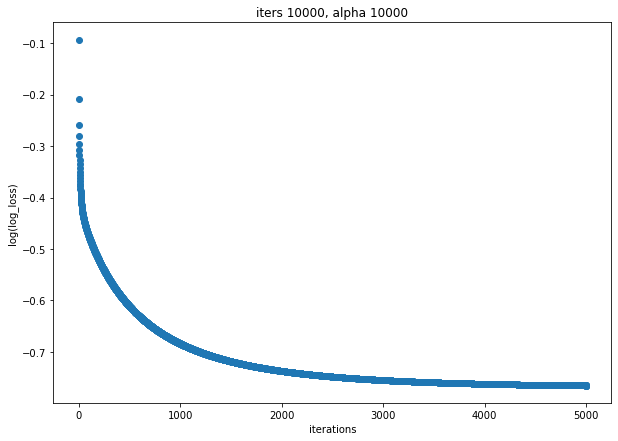

In [94]:
for_graph = np.array(for_graph).T
fig = plt.figure(figsize=(10,7))
plt.title('iters 10000, alpha 10000')
plt.xlabel('iterations')
plt.ylabel('log(log_loss)')
plt.scatter(for_graph[0], np.log(for_graph[1]))
for_graph[1].shape

In [95]:
y_pred = calc_pred(w, np.array(X_test.T), threshold=0.5)


Так же решил посмотреть насколько зависит roc_auc_score от порога.

In [96]:
thresholds = np.linspace(0.3, 0.75, 50)
y_preds1 = [] 
for threshold in thresholds:
    y_pred1 = calc_pred(w, np.array(X_test1.T),threshold=threshold)
    y_preds1.append(roc_auc_score(y_test1, y_pred1))
y_pred1 = calc_pred(w, np.array(X_test1.T))    

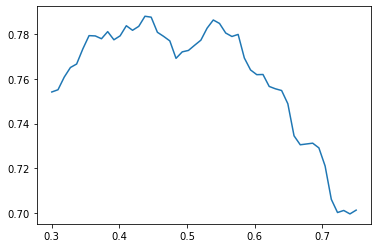

In [97]:
plt.plot(thresholds, y_preds1)

На графике виден весьма странный провал на 0.5, но скорей всего это случайность,

In [98]:
np.unique(y_pred1,return_counts=True)

(array([0., 1.]), array([1453,  547], dtype=int64))

Результат на трейне

In [99]:
roc_auc_score(y_test, y_pred)

0.7638564063875267

Результат на тесте.

In [100]:
roc_auc_score(y_test1, y_pred1)

0.7721391955301201

Теперь посчитаем на полной выборке. И запишем все в файл.

In [101]:
df2_class_one = df2[df2['choose'] == 1]
for i in range(6):
    df2=pd.concat((df2, df2_class_one), ignore_index=True)
y2 = df2.pop('choose')

In [102]:
X = np.array(df2.T)
y = np.array(y2)
w, err , for_graph = eval_model(X, y, iterations=iters, alpha=alpha)

In [105]:
df_test = add_ones(df_test)

In [106]:
answers_kaggle = calc_pred(w, np.array(df_test.T), threshold=0.5)

In [107]:
np.unique(answers_kaggle,return_counts=True)

(array([0., 1.]), array([6308, 3692], dtype=int64))

In [108]:
df_answers = pd.DataFrame(list(range(10000,20000)), columns=('Id',))
df_answers['Choose']= np.round(answers_kaggle)
df_answers.to_csv('hello.csv',sep=',', index=False)

Результат 0.78850.

Заключение.

Достаточно грустно, что такой низкий результат.

Возможно стоило попробовать градиентный бустинг, он подстраивается к ошибке и, возможно, несбалансированность данных на него так сильно не повлияла бы. Или K-means(хотя врядли он должен был выступить лучше, мне кажется несбалансированность классов должна быть для него фатальной.)
Я не успел применить уменьшение размерности матрицы признаков. Но вроде было очень мало признаков, вряд ли это должно было помочь.
Вполне возможно я не смог придумать очевидный признак который придумали все остальные.

Из того что я заметил лес считал важным признак физику, но при этом логистическая регрессия на него практически не обращала внимания, у нас были нормализованы признаки. И коэффициент при физике был маленьким.

Вне рамок курса попробую придумать почему такой плохой результат.

Курс мне очень понравился, было крайне полезно и интересно.

Если несложно, напишите пару слов о том, над чем мне стоит поработать побольше. Спасибо.